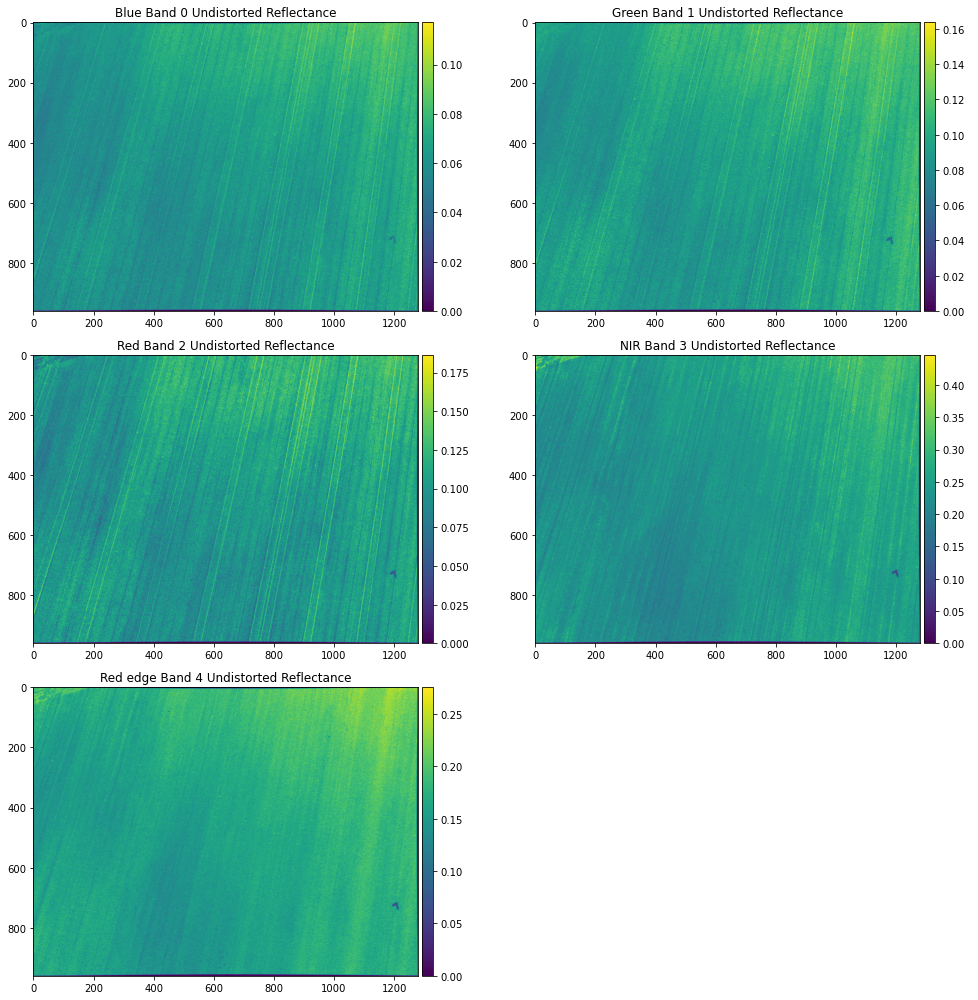

/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000
['/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000/IMG_0077_5.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000/IMG_0077_2.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000/IMG_0077_1.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000/IMG_0077_4.tif', '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/000/IMG_0077_3.tif']


In [1]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# # This is an older RedEdge image without RigRelatives
# imagePath = os.path.join(os.path.abspath('.'),'data','0000SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0001_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))



# # Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
# imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/DataCapture/agri_data_30jul','0021SET'))
# imageNames = glob.glob(os.path.join(imagePath,'000','IMG_0005_*.tif'))  # sets to be aligned
# panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0000_*.tif'))  # corresponding CRP images for metadata


# Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','000'))
imageNames = glob.glob(os.path.join(imagePath,'IMG_0077_*.tif'))  # sets to be aligned
panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))  # corresponding CRP images for metadata


# This is an altum image with RigRelatives and a thermal band
# imagePath = os.path.join('.','data','ALTUM1SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0245_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

export_channels = True
channel_path = '/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/channels'  # to save registered MS channels


if export_channels and not os.path.exists(channel_path):
    os.makedirs(channel_path)


# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)

else:
    panelCap = None


capture = capture.Capture.from_filelist(imageNames)

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance() 


print(imagePath)
print(imageNames)   

# Load the warp matrices

In [2]:
from numpy import array
from numpy import float32
import numpy as np

warp_matrices = np.load('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/warp_matrices.npy')
# warp_matrices = np.load('../MSI/data/DataCapture/calibration.npy')
print(warp_matrices)
print("[INFO] warp matrices loaded...")

[[[ 9.97984886e-01  3.81712429e-03  1.07992115e+01]
  [-6.74913172e-03  9.97700870e-01  3.42201495e+00]
  [-1.97412533e-06 -2.60883166e-06  1.00000000e+00]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00010180e+00  2.66201183e-04  1.63180866e+01]
  [-9.85691557e-04  1.00021434e+00  5.54913330e+00]
  [-1.12014561e-06  3.09240278e-08  1.00000000e+00]]

 [[ 1.00028038e+00  1.76764990e-03  8.68098068e+00]
  [-6.42794836e-03  1.00033152e+00  4.81351042e+00]
  [-3.09991037e-06 -4.81653478e-06  1.00000000e+00]]

 [[ 1.00238883e+00  1.90657005e-03  2.14406090e+01]
  [-2.86875595e-03  9.99445796e-01  5.21580172e+00]
  [ 1.80997154e-06 -3.36434141e-06  1.00000000e+00]]]
[INFO] warp matrices loaded...


In [3]:
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None


    
sample = capture.create_aligned_capture(irradiance_list=irradiance, warp_matrices=warp_matrices)
print("[INFO] Multispectral channels registered...")

[INFO] Multispectral channels registered...


In [ ]:
print(imageNames[0])

In [4]:
print(sample.dtype)

float32


In [ ]:
import hdf5storage
def save_matv73(mat_name, var_name, var):
    hdf5storage.savemat(mat_name, {var_name: var}, format='7.3', store_python_metadata=True)

In [ ]:
save_matv73('sample', 'cube', sample)

# Saving the aligned channels